# Airbnb Analysis

In [3]:
#Magic plots after each cell
%matplotlib inline

#Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
#Read clean file and convert to CSV
data_file = pd.read_csv("Resources/CleanAirbnbData.csv")
abb_df = pd.DataFrame(data_file)
abb_df.head()

,ID,Name,Host ID,Host Name,Neighbourhood Group,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Calculated Host Listings Count,Availability
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
#Create dictionary for most up to date population by data by borough (2018 estimates by nyc.gov)
pop_dict = {'Brooklyn': 2582830,
            'Bronx': 1432132,
            'Manhattan': 1628701,
            'Queens': 2278906,
            'Staten Island': 476179
           }

## Who is using Airbnb in NYC?

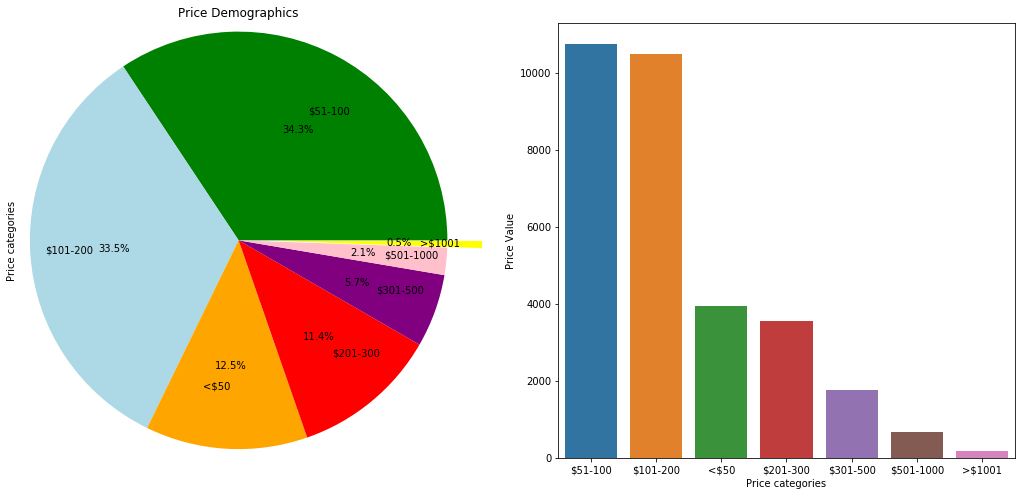

In [29]:
price_bins = [0,50,100,200,300,500,1000, max(abb_df['Price'])]
price_group_names =["<$50","$51-100","$101-200","$201-300","$301-500","$501-1000",">$1001"]
abb_df["Price categories"] = pd.cut(abb_df["Price"], price_bins, labels=price_group_names)

f,ax=plt.subplots(1,2,figsize=(18,8))
colors = ["green","lightblue","orange","red","purple","pink","yellow"]
abb_df['Price categories'].value_counts().plot.pie(explode=[0,0,0,0,0,0,0.2],colors = colors, autopct='%1.1f%%',ax=ax[0],labeldistance=0.7,radius=1.2)
ax[0].set_title('Price Demographics')

sns.countplot('Price categories',data=abb_df,ax=ax[1],order=abb_df['Price categories'].value_counts().index)
ax[1].set_ylabel('Price Value')

plt.savefig('Output/Price Demographics')
# plt.show()

In [44]:
min_p = min(abb_df['Price'])
max_p = max(abb_df['Price'])
mean_p = round(abb_df['Price'].mean(),2)
# print(f'min price:{min_p}, max price:{max_p},mean_p:{mean_p}')
price_dict={"Minimum Price":[min_p], "Maximum Price":[max_p],"Mean Price":[mean_p]}
price_df = pd.DataFrame(price_dict)
price_df  

,Minimum Price,Maximum Price,Mean Price
0,0,10000,162.05


In [46]:
# List Demographics
list_bins = [0,1,5, 10, 20,30,50,100,200,max(abb_df['Calculated Host Listings Count'])]
list_group_names =['1_list','2-5','6-10','11-20','21-30','31-50','51-100','101-200','>201']
abb_df["List Categories"] = pd.cut(abb_df["Calculated Host Listings Count"], list_bins, labels=list_group_names)
List_Demographics = pd.DataFrame(abb_df["List Categories"].value_counts())
List_Demographics.reset_index()
List_Demographics["Percentage of listing"]= round(List_Demographics["List Categories"]/ List_Demographics["List Categories"].sum() *100,2)

List_Demographics.rank(axis=0, numeric_only=False)
List_Demographics


,List Categories,Percentage of listing
1_list,17393,55.46
2-5,9370,29.88
6-10,1731,5.52
11-20,712,2.27
>201,559,1.78
31-50,556,1.77
51-100,526,1.68
21-30,302,0.96
101-200,213,0.68


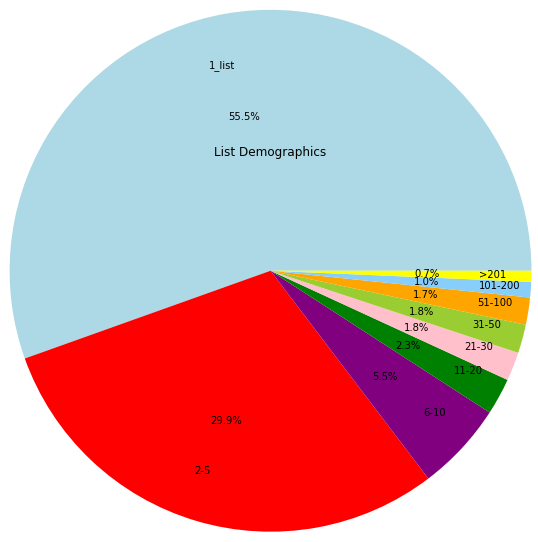

In [51]:
pies = ['1_list','2-5','6-10','11-20','21-30','31-50','51-100','101-200','>201']
pie_votes = List_Demographics["Percentage of listing"]
colors = ["lightblue","red","purple","green","pink","yellowgreen","orange","lightskyblue","yellow"]
plt.pie(pie_votes, labels=pies,colors=colors,autopct="%1.1f%%",radius=3,labeldistance=0.8)
plt.title('List Demographics')
plt.savefig("Output/List Demographics")
plt.show()

## How is Airbnb used in the different boroughs? 

## How do the demographics for each borough affect their Airbnb use? 

## What other external variables may be factors for Airbnb's usage in each area?